## Analyzing Used Car Market in Sweden

The project analyzes data scraped from one of Europe's most popular used car listing sites[AutoUncle](https://www.autouncle.se/) and build an ML model that can predict used car prices based on a number of features thereby identifying undervalued or overvalued vehicles in Sweden automobile market.

The data used in the project is collected by webscraping [Autouncle](https://www.autouncle.se/).


### Limitations of the Project

 While the project effectively predicts used car prices and identifies undervalued or overvalued vehicles based on key features like mileage, year, brand, model, transmission, and fuel type, it does not currently account for additional factors that could significantly influence valuation. These factors include the condition of the car (The physical and mechanical state of the car , which is a critical factor for buyers and sellers in assessing value of used cars), prior ownership, engine power, and Geographic pricing trends.  Incorporating these factors in future iterations could enhance the model's accuracy and provide a more comprehensive understanding of the factors driving used car prices.

### Goal

1. Data Acquisition: Collect real-world automobile market data from online sources, leveraging web scraping or available listings, to create a comprehensive dataset of vehicle information.

2. Data Cleaning and Preparation: Process and filter the collected dataset to ensure accuracy and consistency. This includes handling missing values, correcting misaligned data, and standardizing features, making the dataset ready for in-depth analysis and modeling.

3. Machine Learning Model for Price Valuation: Develop a robust machine learning model to estimate automobile prices. The model will use key features such as Mileage, Year, Brand, Model, Transmission, and Fuel Type to predict prices with practical accuracy. The aim is to create a tool that is useful and reliable for price evaluation in real-world scenarios.

4. Market Insights: Analyze the cleaned data and model predictions to uncover meaningful insights about the used car market in Sweden. These insights will support informed decision-making, particularly when purchasing vehicles.

5. Actionable Recommendations: Utilize the model and insights to identify undervalued or overvalued vehicles. This will provide actionable opportunities for both buyers and sellers, helping buyers find good deals and sellers optimize their pricing strategies.

### Workflow

1. Data collection : acquire data by webscraping Europe's largest used car site 'autouncle.se'.

2. Data Cleaning : clean, create new features , and transform the scraped dataset in to an analysis ready format.

3. Feature Engineering: Explore additional features, create new features.
    
4. Explore and visualize the data to uncover patterns and anomalies.

5. Data Pre-processing and Build predictive models using machine learning algorithms.

5. Insights and Recommendations

## 1. Import Libraries and Load Data

The webscraping part of this project is found in another file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [48]:
# removes warnings
import warnings
warnings.filterwarnings('ignore')

#suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

In [86]:
# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath)

cars_df = load_data('cars.csv')

## 2. Data Cleaning

The dataset is quite messy, and the following steps will be performed systematically to clean and preprocess it:

1.Handle Missing Values:

Identify rows where the Model_Year (in formats like "Year" or "Month Year") is missing.
Remove these rows from the dataset, as the Model_Year is a critical feature.

2.Fix Misaligned Rows:

Address misalignment issues observed in the Model_Year column, where values like '1 / 1', '1 / 2', and '1 / 3' were incorrectly assigned.
Shift such misaligned values to their correct columns.

3.Gearbox Column Issues:

Drop rows where the Gearbox column does not have valid values, i.e., Automatic or Manual.
Remove the Gearbox2 column, as it is redundant and no longer needed.

4.Feature Extraction:

Extract the brand name from the Name column into a new column, Brand.
Extract the model name from the Name column into a new column, Model.

5.Location Cleaning:

Extract only the city name from the Location column into a new column, City.

6.Price Column Cleaning:

Remove the 'kr' suffix from the Price column and convert it to an integer data type.

7.Model_Year Column Cleaning:

Extract only the year value from the Model_Year column, discarding additional information like month names.

8.Combine Brand and Model:

Create a combined column, Brand_Model, to analyze the popularity of specific car models.

9.Mileage Column Cleaning:

Remove rows where the Mileage column contains values like Electric, which are not valid mileage values.
Remove the ' mil' suffix from mileage values and convert the column to an integer data type.

10.Remove Unnecessary Columns:

Drop columns that are irrelevant or redundant after the cleaning process.

11.Data Type Conversion:

Ensure all columns have the appropriate data types (e.g., numeric for mileage, price, and year).

In [95]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        3275 non-null   object
 1   Price       3275 non-null   object
 2   Location    3275 non-null   object
 3   Model_Year  3275 non-null   object
 4   Mileage     3275 non-null   object
 5   Fuel_Type   3275 non-null   object
 6   Gearbox     3266 non-null   object
 7   Gearbox2    2180 non-null   object
dtypes: object(8)
memory usage: 204.8+ KB


In [97]:
def fix_gear(row):
    if 'km' in str(row['Gearbox']):
        row['Gearbox'] = row['Gearbox2']
        row['Gearbox2'] = None
    return row

# Define a function to fix rows where Model_Year consists of '/'
def fix_row(row):
    if '/' in str(row['Model_Year']):
        row['Model_Year'] = row['Mileage']  # Assign 'Mileage' to 'Model_Year'
        row['Mileage'] = row['Fuel_Type']  # Assign 'Fuel_Type' to 'Mileage'
        row['Fuel_Type'] = row['Gearbox']  # Assign 'Gearbox' to 'Fuel_Type'
        row['Gearbox'] = row['Gearbox2']  # Assign 'Gearbox2' to 'Gearbox'
        row['Gearbox2'] = None  # Clear 'Gearbox2' as it is no longer needed
    return row


def correct_data_types(df):
    df['Price'] = df['Price'].replace('kr', '', regex=True).astype(int)
    df['Mileage'] = df['Mileage'].astype(str).str.replace(r'\D', '', regex=True)
    df['Mileage'] = df['Mileage'].replace('', np.nan).astype(float).astype('Int64')
    df['Year'] = df['Model_Year'].str.extract(r'(\b\d{4}\b)').astype(float)  # Extract year as float
    df = df.dropna(subset=['Year'])  # Drop rows where Year is NaN
    df['Year'] = df['Year'].astype(int)  # Convert remaining years to int
    return df

def clean_data(df):
    df = df.apply(fix_gear, axis=1)
    df = df[df['Gearbox'].isin(['Manual', 'Automatic'])]
    df = df.drop('Gearbox2', axis=1)
    df = df[df['Mileage'] != 'Electric'].reset_index(drop=True)
    df = correct_data_types(df)
    df.rename(columns={'Gearbox': 'Transmission'}, inplace=True)
    df = df.apply(fix_row, axis=1)
    return df

cars_df = clean_data(cars_df)

In [98]:
cars_df.shape

(2650, 8)

## 3. Feature Engineering

- create new column such as Brand, Brand_Model from Name
- categorize Fuel_Type column in to specified six groups
- create a new column called County from the Location column consisting only the county name
- create a new column called Price_per_Mile  to get insights into the value proposition of a car based on its cost and how much it has been driven.

The location column has some information that needs to be updated in order to extract a County column.

A function is used to extract the county from the location column.

Lower Price per Mileage indicates Better Value for Money(Usually). 
Higher Price per Mileage indicates a Premium Car or Newer Condition.

In [99]:
# Feature Engineering

def feature_engineering(df):
    # Create a Price_per_Mile feature
    df['Price_per_Mile'] = df['Price'] / df['Mileage']
    
    # Extract the brand name from the Name column
    df['Brand'] = df['Name'].str.split(' ').str[0]
    
    # Extract the model name from the Name column
    df['Brand_Model'] = df['Name'].str.split().str[:2].str.join(' ')
    
    
    # Categorize the Fuel_Type column
    def categorize_fuel_type(fuel_type):
        if 'Electric' in fuel_type and '/' not in fuel_type:
            return 'Electric'
        elif 'Hybrid' in fuel_type or 'Electric/' in fuel_type:
            return 'Hybrid'
        elif 'Petrol' in fuel_type and 'Electric/' not in fuel_type:
            return 'Petrol'
        elif 'Diesel' in fuel_type and 'Electric/' not in fuel_type:
            return 'Diesel'
        elif 'Natural gas' in fuel_type:
            return 'Natural Gas'
        else:
            return 'Ethanol'
    
    # Apply the categorization to the Fuel_Type column
    df['Fuel'] = df['Fuel_Type'].apply(categorize_fuel_type)
    
    # Extract the county from the Location column
    def extract_city(location):
        if 'Delivered to you' in location:
            return None  # Mark rows with 'Delivered to you' for deletion
        elif ',' in location:
            return location.split(',')[1].strip()  # Extract county after comma
        else:
            return location.strip()  # If no comma, return the full location as county
    
    df['County'] = df['Location'].apply(extract_city)
    
    # Drop rows where County is None
    df = df.dropna(subset=['County'])
    
    return df

# Apply feature engineering
cars_df = feature_engineering(cars_df)

Retain only the observations in the County column where the count of occurrences is more than 2.

In [100]:
# Remove counties with 1 or 2 observations in the dataset.
county_counts = cars_df['County'].value_counts()
counties_to_keep = county_counts[county_counts > 2].index

# Keep only rows where the County column is in the list of counties to keep
cars_df = cars_df[cars_df['County'].isin(counties_to_keep)]

In [101]:
cars_df=cars_df.reset_index(drop=True)

## 4.Exploratory Data Analysis (EDA)

##### Price
Distribution of Price of cars

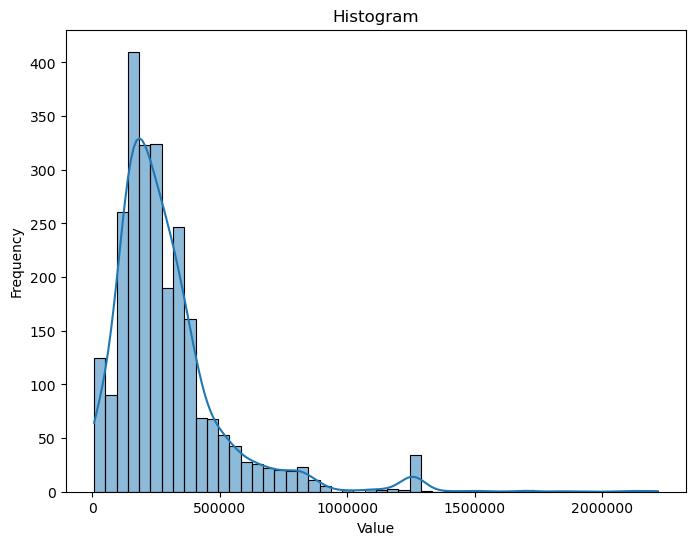

In [102]:
plt.figure(figsize=(8, 6))
sns.histplot(cars_df['Price'], bins=50, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.ticklabel_format(style='plain')
plt.show()

##### Brand and Model
Which car brands and models are most available in Sweden?

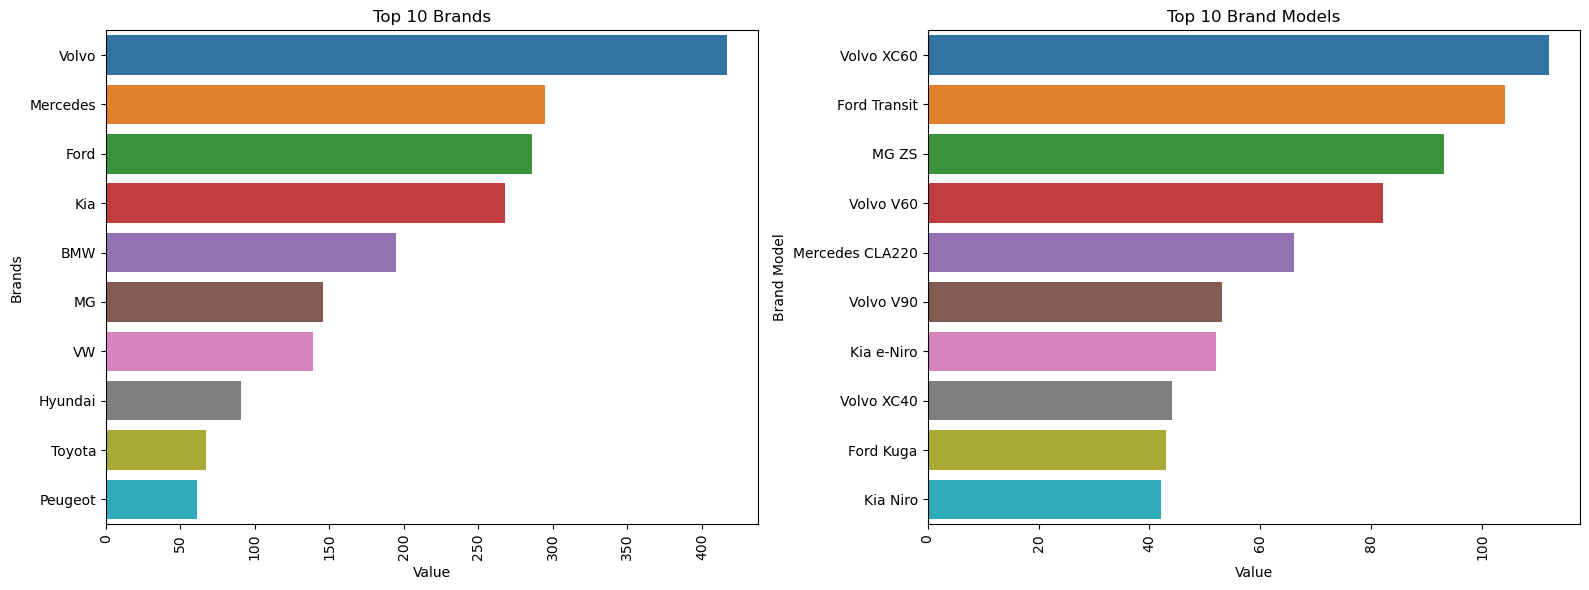

In [103]:

# Data for Brand
var_brand = cars_df['Brand']
var_brand_value_counts = var_brand.value_counts().head(10)

# Data for Brand Model
var_brand_model = cars_df['Brand_Model']
var_brand_model_value_counts = var_brand_model.value_counts().head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Brand
sns.barplot(ax=axes[0], x=var_brand_value_counts, y=var_brand_value_counts.index)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Brands')
axes[0].set_title('Top 10 Brands')
axes[0].tick_params(axis='x', rotation=90)

# Plot for Brand Model
sns.barplot(ax=axes[1], x=var_brand_model_value_counts, y=var_brand_model_value_counts.index)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Brand Model')
axes[1].set_title('Top 10 Brand Models')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

As expected, The brand which is sold the most in Sweden is Volvo followed by Mercedes.

Volvo has 4 different models in the 10 most popular model category.

##### Relationship between Price, Mileage and Year

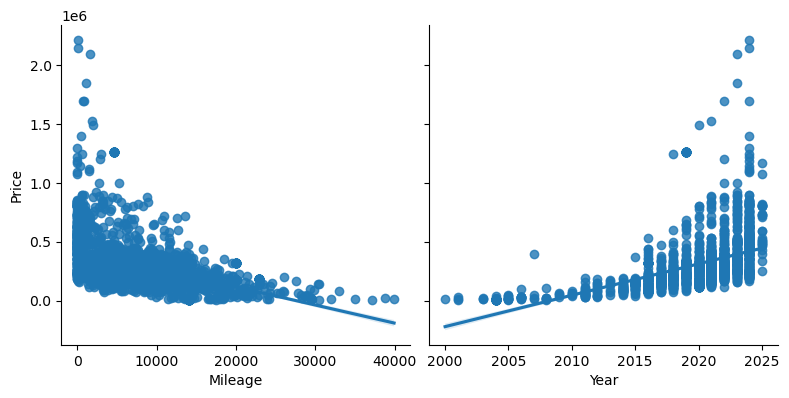

In [105]:
# Create the pairplot
sns.pairplot(cars_df, 
             x_vars=['Mileage', 'Year'],
             y_vars='Price',
             diag_kind='auto',
             kind='reg',
             height=4)

# Show the plot
plt.show()

As the mileage increases, the price of a car decreases. In other words cars with high mileage numbers are sold cheaper on the market.

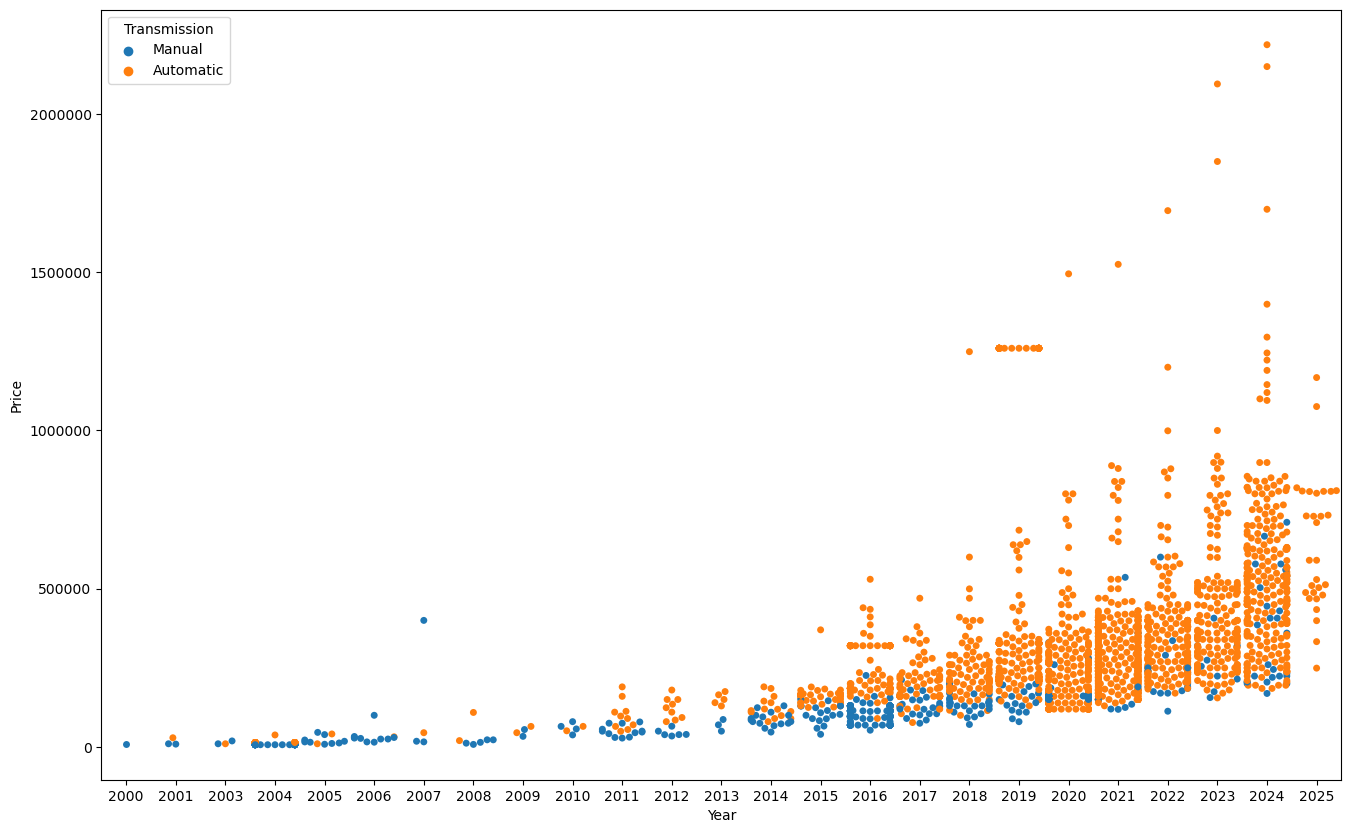

In [108]:
plt.figure(figsize = (16,10))
plt.ticklabel_format(style='plain')
sns.swarmplot(x = 'Year',y = 'Price',data = cars_df,hue='Transmission')
plt.show()

As expected cars with recent make years on average are more expensive on the market. 

There is a noticeable difference in prices between cars with different transmission types within the same year. This is particularly evident in recent years, cars with automatic transmission tend to be priced higher than cars with manual transmission.

In [109]:
cars_df.groupby('Fuel')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel,,,,,,,,
Diesel,739.00,238123.64,119528.87,20000.00,150000.00,219900.00,309000.00,879000.00
Electric,536.00,346204.78,198125.86,77100.00,199800.00,279900.00,445625.00,1295000.00
Ethanol,10.00,301810.00,84606.49,189900.00,223650.00,317400.00,379675.00,399900.00
Hybrid,424.00,400618.00,234209.87,64900.00,244900.00,339900.00,489900.00,2149900.00
Natural Gas,4.00,289943.75,256557.91,33500.00,87050.00,306950.00,509843.75,512375.00
Petrol,861.00,252505.38,284878.42,7000.00,113900.00,189900.00,289900.00,2219000.00


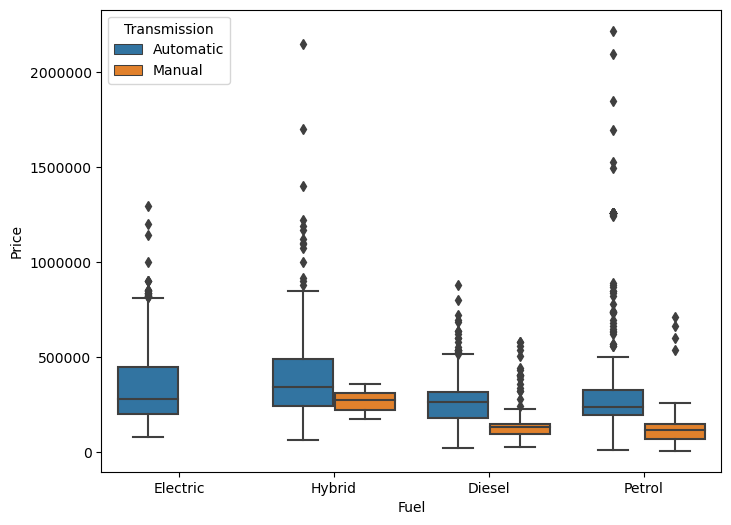

In [117]:
#remove Ethanol(10), and Natural Gas(4) from this specific plot as these cars are very few in numbers
data=cars_df[cars_df['Fuel'].isin(['Diesel','Petrol','Electric','Hybrid'])]
plt.figure(figsize=(8,6))
plt.ticklabel_format(style='plain')
sns.boxplot(x='Fuel',y='Price',data=data,hue='Transmission')
plt.show()

Cars with diesel and petrol fuel types are relatively cheaper in the market than Hybrid and Electric Vehicles.

##### Prices of Used Cars among Sweden's Counties

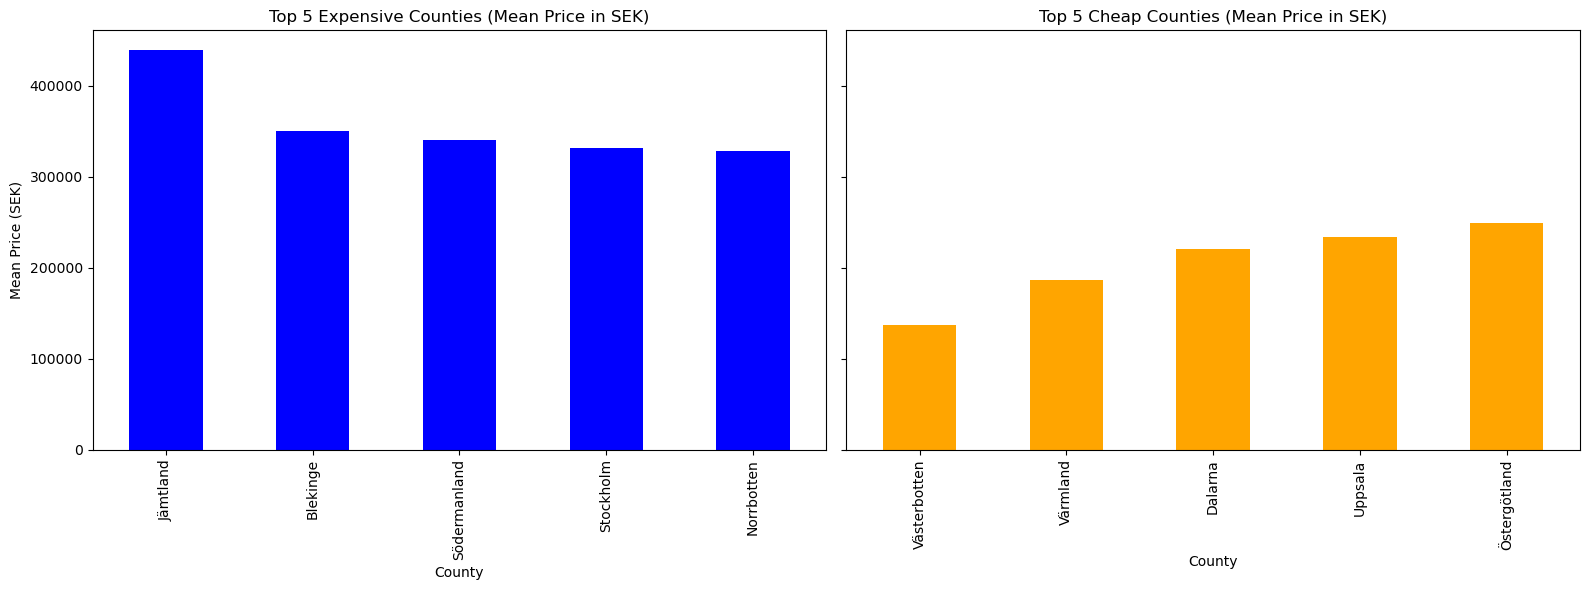

In [115]:
# Calculate the mean prices for expensive and cheap counties
expensive_counties = cars_df.groupby(['County'])['Price'].mean().sort_values(ascending=False).head()
cheap_counties = cars_df.groupby(['County'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive counties
expensive_counties.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Counties (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the cheap counties
cheap_counties.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Cheap Counties (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()


It is much cheaper to buy cars in Västerbotten,Värmland, Dalarna and Uppsala counties than anywhere else in Sweden.

Budget-conscious buyers should look closely for cars in these places.

Average Prices of cars in Jämtland, Blekinge, Södermanland, and Stockholm counties are more expensive than other counties. 

##### Prices of Cars Vs. Brands

Which car brands have the highest and lowest average prices in Sweden?

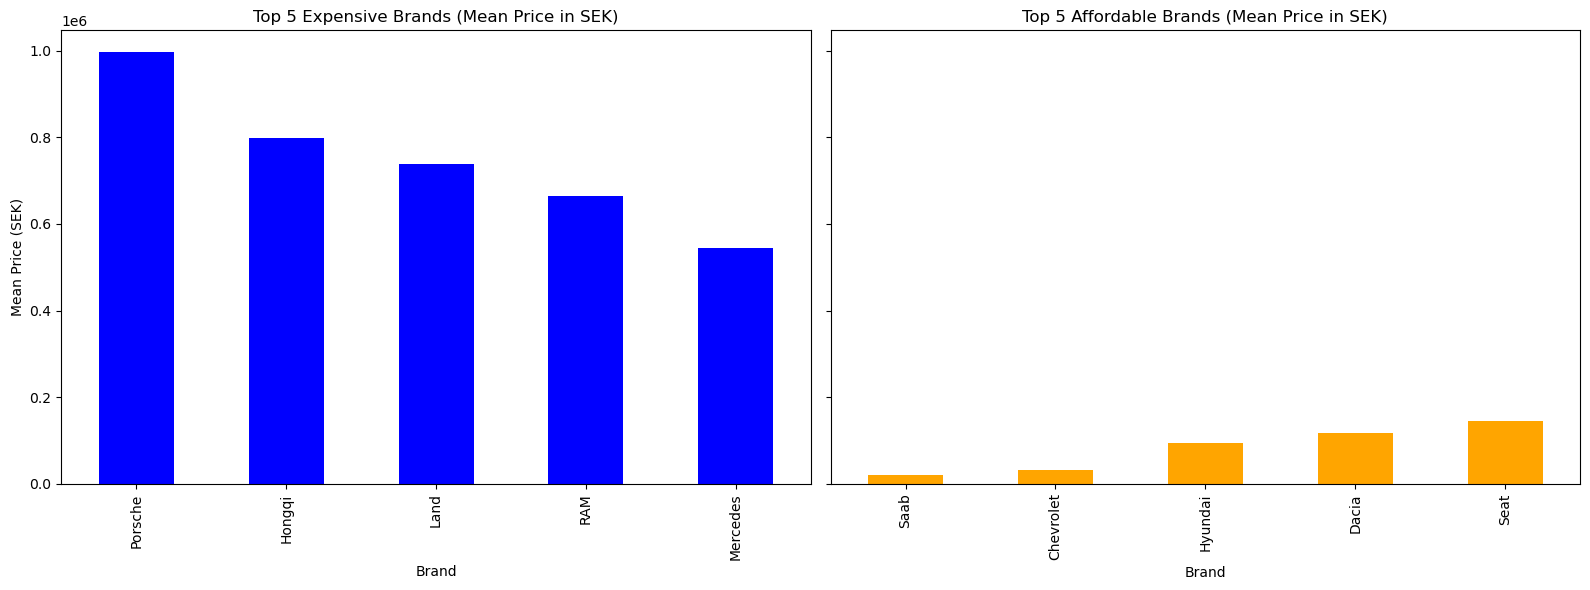

In [116]:
# Calculate the mean prices for expensive and cheap car brands
steep_brand = cars_df.groupby(['Brand'])['Price'].mean().sort_values(ascending=False).head()
affordable_brand = cars_df.groupby(['Brand'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive brands
steep_brand.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Brands (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the affordable brands
affordable_brand.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Affordable Brands (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()

## 5. Data Pre-Processing and Modeling

- select important features
- convert categorical columns to numeric.
  
  Most machine learning algorithms require numerical inputs to make predictions. 

  Some of these features have categorical formats and need to be converted in to numeric.
  Brand, Fuel, and Transmission will be converted to numeric format. the technique chosen is One-hot encoding  as the columns are nominal (has no natural order).
- Feature Scaling
  Normalize or standardize numeric features to ensure they are on a comparable scale.
- Train ML models and compare model performances
- Hyperparameter tuning the selected model to achieve better performances using GridSearchCV
- Feature Importance: identify which features are more important

In [118]:
# Feature Engineering
df = cars_df[['Brand', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price_per_Mile', 'Price']]

# One-Hot Encoding for categorical variables
dummies = pd.get_dummies(df[['Brand', 'Fuel', 'Transmission', 'County']], drop_first=True, dtype='int')
df = df.drop(['Brand', 'Fuel', 'Transmission', 'County'], axis=1)
df = pd.concat([df, dummies], axis=1)

# Define feature matrix X and target variable y
X = df.drop('Price', axis=1)
y = df['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Standardize the feature matrix
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=101),
    "Decision Tree": DecisionTreeRegressor(random_state=101),
    "Support Vector Regressor": SVR()
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2 Score": r2}

# Display the results
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.2f}, R2 Score = {metrics['R2 Score']:.2f}")

# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(RandomForestRegressor(random_state=101), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the optimized Random Forest model
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nOptimized Random Forest Performance:")
print(f"RMSE = {rmse_best_rf:.2f}, R2 Score = {r2_best_rf:.2f}")

Training Linear Regression...
Training Random Forest...
Training Decision Tree...
Training Support Vector Regressor...

Model Performance:
Linear Regression: RMSE = 162501.64, R2 Score = 0.57
Random Forest: RMSE = 75381.38, R2 Score = 0.91
Decision Tree: RMSE = 84720.71, R2 Score = 0.88
Support Vector Regressor: RMSE = 254496.38, R2 Score = -0.06

Performing Grid Search for Random Forest...
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Optimized Random Forest Performance:
RMSE = 75471.26, R2 Score = 0.91


##### Feature Importance

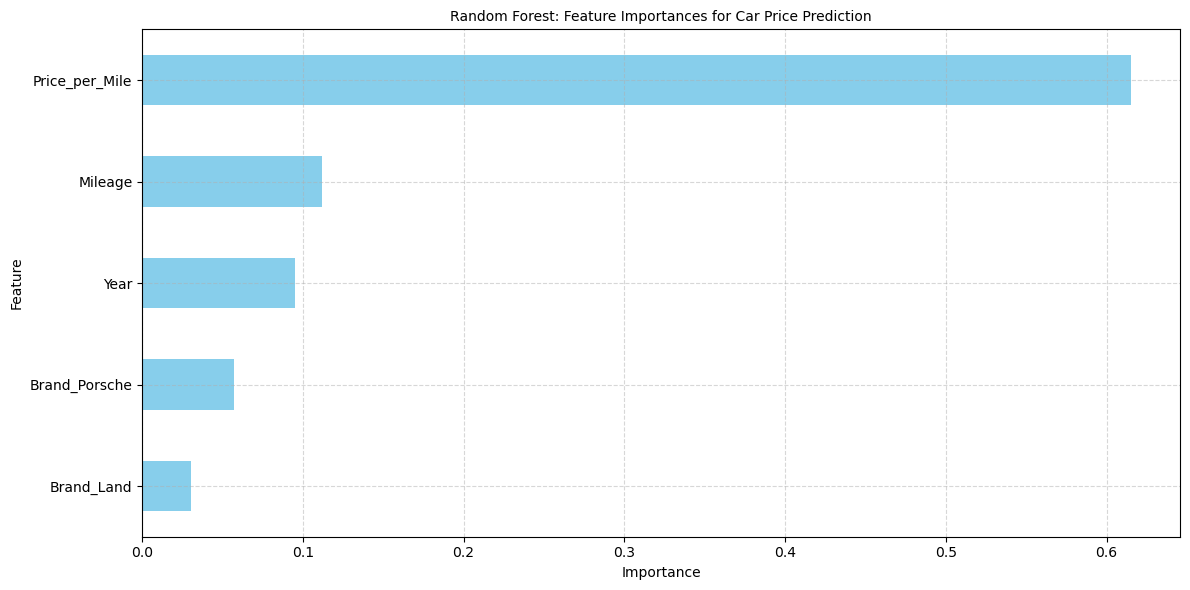

In [119]:
# Create a Pandas Series to store feature importances from the model
feature_rank=pd.Series(best_rf.feature_importances_,index=X_train.columns,name='Importance').sort_values(ascending=True,inplace=False)[-5:]

# Plotting a horizontal bar chart to visualize feature importances
ax=feature_rank.plot(kind='barh',figsize=(12,6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot 
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Car Price Prediction", fontsize=10)

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show();

Price per mile driven, Mileage and The make year were the most important features in predicting the value of a car.

## 6. Insights and Recommendations

The Random Forest model saved will be used to identify undervalued cars. 
 It is done by comparing predicted prices to actual prices and flagging those with a significant gap. 

##### Save and Load the Model

In [123]:
import joblib

joblib.dump(best_rf, 'rf_model.pkl')

['rf_model.pkl']

In [124]:
# Load the saved model
import joblib
loaded_model = joblib.load('rf_model.pkl')

In [125]:
# Predict prices using the test set
predictions=loaded_model.predict(X_test)

##### Set a threshold to identify undervalued cars

In [131]:
# Create a DataFrame with actual, predicted, and price difference
undervalued_df = pd.DataFrame({
    'Actual': y_test,
    'Predictions': predictions
})

# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%, select those cars with a price difference that is higher than 10% of the the car's true price.
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars early
undervalued_df = undervalued_df[undervalued_mask]

# Add 'Brand' and 'Brand_Model' details from the original dataset so that we can see which Brand and Model
undervalued_with_details = undervalued_df.join(cars_df[['Brand', 'Brand_Model','Fuel','Transmission','Mileage','Year','Location']], how='left')
undervalued_with_details.head()

,Actual,Predictions,Price_Difference,Brand,Brand_Model,Fuel,Transmission,Mileage,Year,Location
240,739500,916317,176817,BMW,BMW M340,Petrol,Automatic,613,2023,"302 24 Halmstad, Halland"
988,299900,339744,39844,Fiat,Fiat Scudo,Diesel,Automatic,400,2023,"754 54 Uppsala, Uppsala"
1123,339900,664865,324965,Mercedes,Mercedes eCitan,Electric,Automatic,300,2023,"754 54 Uppsala, Uppsala"
748,194900,226951,32051,Dacia,Dacia Sandero,Petrol,Automatic,300,2024,"432 32 Varberg, Halland"
1329,205900,380260,174360,Peugeot,Peugeot e-2008,Electric,Automatic,664,2021,"113 29 Stockholm, Stockholm"


In [133]:
len(undervalued_with_details)

45

According to the random forest model, the 45 listed cars above are the most undervalued cars in the dataset,that are priced significantly below their predicted value, signaling potential bargains.

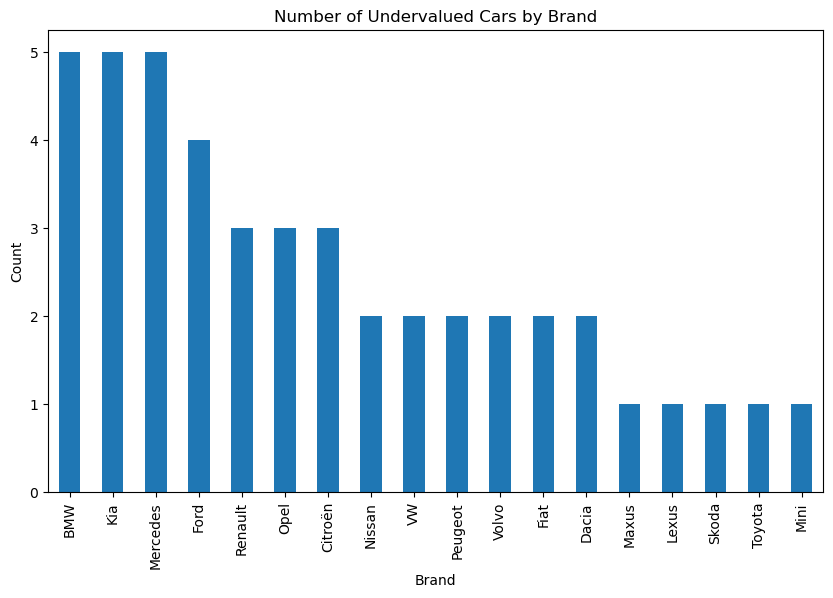

In [134]:
# Plot undervalued cars by brand
undervalued_with_details.groupby('Brand').size().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Number of Undervalued Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

The random forest model not only predicts the prices of used cars but also provides actionable insights for identifying potential opportunities in the market for both sellers as well as buyers.


While the project effectively predicts used car prices and identifies undervalued or overvalued vehicles based on key features like mileage, year, brand, model, transmission, and fuel type, it does not currently account for additional factors that could significantly influence pricing. These factors include:

- Car Condition: The physical and mechanical state of the vehicle, such as wear and tear, accident history, or maintenance records.
- Engine Power: Technical specifications like engine power and performance that often play a crucial role in price valuation.
- Previous Ownership: The number of prior owners, which can impact a car's perceived value and desirability.
- Geographic Pricing Trends: Regional or city-based price differences due to demand, supply, or local market trends.